In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBRegressor

import shap


In [8]:
# Загрузка данных
data = pd.read_csv('data_for_modeling.csv')

# Заполнение пропусков
def fill_missing_values(df):
    columns_with_nans = [
        'avg_temp_last_3_days',
        'avg_precip_last_3_days',
        'season_encoded_cos',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos'
    ]

    for col in columns_with_nans:
        df[col] = df[col].interpolate(method='time').fillna(method='bfill').fillna(method='ffill')

    return df

# Функция для предобработки данных
def preprocess_data(df):
    df['log1p'] = np.log1p(df['units'])  # Логарифмическое преобразование целевой переменной

    # Преобразование даты
    df['date'] = pd.to_datetime(df['date'])
    df['date2j'] = (df['date'] - pd.to_datetime("2012-01-01")).dt.days  # Дни с начала 2012 года
    # Удаление данных за 2013-12-25 так как там много нулей
    df = df[df['date'] != '2013-12-25']


    # Создание признаков для погоды
    df['preciptotal_flag'] = np.where(df['preciptotal'] > 0.2, 1.0, 0.0)  # Флаг осадков
    df['depart_flag'] = np.where(df['depart'] < -8.0, -1, np.where(df['depart'] > 8.0, 1, 0))

    # Создание временных признаков
    df['weekday'] = df['date'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    # Можно еще добавить (предложил GPT)
    # Создание временных признаков
    #df['day_of_week'] = df['date'].dt.dayofweek
    #df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    #df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    #df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    #df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


    # Агрегация погодных признаков за неделю
    df['week'] = df['date'].dt.isocalendar().week
    if 'temperature' in df.columns and 'precipitation' in df.columns:
        agg_weather = df.groupby(['store_nbr', 'week']).agg({
            'temperature': ['mean', 'max', 'min'],
            'preciptotal': ['sum', 'mean']
        })
        agg_weather.columns = ['_'.join(col) for col in agg_weather.columns]
        agg_weather.reset_index(inplace=True)
        df = df.merge(agg_weather, on=['store_nbr', 'week'], how='left')

        # Взаимодействия признаков(предложил GPT)
        #df['temp_precip_interaction'] = df['temperature_mean'] * df['preciptotal_sum']

    # Кодирование категорий
    #df = pd.get_dummies(df, columns=['store_nbr'], drop_first=True)


    return df

# Препроцессинг данных
data = preprocess_data(data)

# Функция для создания признаков на основе скользящего среднего
def create_rolling_mean(df, window=21): #10 дней до и 10 дней после
    df['rmean'] = df['log1p'].rolling(window=window, center=True).mean()
    df['rmean'] = df['rmean'].interpolate().ffill().bfill()  # Интерполяция и заполнение пропусков
    return df

# Применение функции для создания скользящего среднего
data = create_rolling_mean(data)

# Функция для создания признаков нулевых значений
def create_zero_features(df):
    df['is_zero'] = (df['log1p'] == 0).astype(int)

    # Признаки для последовательных нулей
    for i in range(1, 11):
        df[f'forward_zeros_{i}'] = df['is_zero'].shift(-i).fillna(0).astype(int)
        df[f'backward_zeros_{i}'] = df['is_zero'].shift(i).fillna(0).astype(int)

    df['total_forward_zeros'] = df[[f'forward_zeros_{i}' for i in range(1, 11)]].sum(axis=1)
    df['total_backward_zeros'] = df[[f'backward_zeros_{i}' for i in range(1, 11)]].sum(axis=1)

    return df

# Применение функции для создания признаков нулевых значений
data = create_zero_features(data)

# Создание новых погодных признаков
def create_weather_features(df):
    df['avg_daily_sales_item'] = df['units'].rolling(window=7).mean()  # Пример создания среднего
    return df

# Применение функции для создания погодных признаков
data = create_weather_features(data)

# Сохранение предобработанных данных
data.to_csv('preprocessed_data.csv')




<ipython-input-8-d4581b2854c0>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preciptotal_flag'] = np.where(df['preciptotal'] > 0.2, 1.0, 0.0)  # Флаг осадков
<ipython-input-8-d4581b2854c0>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depart_flag'] = np.where(df['depart'] < -8.0, -1, np.where(df['depart'] > 8.0, 1, 0))
<ipython-input-8-d4581b2854c0>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [10]:
# Функция для создания обучающей выборки
def create_training_data(df):
    # Добавляем новые погодные признаки
    df_train = df[['date', 'store_nbr', 'item_nbr', 'log1p', 'rmean', 'is_zero',
                   'total_forward_zeros', 'total_backward_zeros',
                   'tmax', 'tmin', 'tavg', 'snowfall', 'preciptotal',
                   'is_holiday', 'day_of_week_sin', 'day_of_week_cos',
                   'month_sin', 'month_cos', 'avg_daily_sales_item']]
    return df_train

# Создание обучающей выборки
df_train = create_training_data(data)

# Сохранение обучающей выборки
df_train.to_csv('train_data.csv')

# Загрузка предобработанных данных
df_train = pd.read_csv('train_data.csv')

# Преобразование столбца даты в отдельные числовые признаки
df_train['date'] = pd.to_datetime(df_train['date'])

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['weekday'] = df_train['date'].dt.weekday

# Удаление оригинального столбца даты
df_train.drop(columns=['date'], inplace=True)




In [11]:
def train_and_evaluate_models(df_train, target_col='log1p', test_size=0.2, random_state=42):
    """
    Обучает XGBoost, RandomForest и LinearRegression модели на данных df_train.

    Параметры:
    - df_train: DataFrame с признаками и целевой переменной
    - target_col: имя столбца с целевой переменной
    - test_size: доля тестовой выборки
    - random_state: для воспроизводимости

    Возвращает:
    - models: dict с обученными моделями
    - metrics: dict с RMSE для каждой модели на тесте
    """
    # Разделение признаков и целевой переменной
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]

    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Заполнение пропусков средним значением
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # XGBoost с GridSearchCV
    xgb_model = XGBRegressor(random_state=random_state, objective='reg:squarederror')
    params_xgb = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    }
    grid_xgb = GridSearchCV(xgb_model, params_xgb, cv=3, scoring='neg_root_mean_squared_error', verbose=0)
    grid_xgb.fit(X_train_imputed, y_train)

    # Random Forest с GridSearchCV
    rf_model = RandomForestRegressor(random_state=random_state)
    params_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }
    grid_rf = GridSearchCV(rf_model, params_rf, cv=3, scoring='neg_root_mean_squared_error', verbose=0)
    grid_rf.fit(X_train_imputed, y_train)

    # Линейная регрессия
    lr_model = LinearRegression()
    lr_model.fit(X_train_imputed, y_train)

    # Оценка моделей
    models = {
        'XGBoost': grid_xgb.best_estimator_,
        'RandomForest': grid_rf.best_estimator_,
        'LinearRegression': lr_model
    }

    metrics = {}
    for name, model in models.items():
        preds = model.predict(X_test_imputed)
        rmse = mean_squared_error(y_test, preds)  # RMSE
        metrics[name] = rmse
        print(f"{name} RMSE: {rmse:.4f}")

    return models, metrics, imputer

In [12]:
# Импортируем функцию
models, metrics, imputer = train_and_evaluate_models(df_train)

print(metrics)

# Доступ к обученным моделям:
xgb_model = models['XGBoost']
rf_model = models['RandomForest']
lr_model = models['LinearRegression']


XGBoost RMSE: 0.1125
RandomForest RMSE: 0.0937
LinearRegression RMSE: 0.7922
{'XGBoost': 0.11253578707890598, 'RandomForest': 0.09370452500905364, 'LinearRegression': 0.7922452596764846}


In [13]:
# Коэффициенты линейной регрессии
feature_names = df_train.drop(columns=['log1p']).columns
coefficients = models['LinearRegression'].coef_

for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.4f}")


Unnamed: 0: 0.0000
store_nbr: -0.0003
item_nbr: -0.0081
rmean: 0.5099
is_zero: -2.5233
total_forward_zeros: 0.0734
total_backward_zeros: 0.1162
tmax: 0.3682
tmin: 0.1032
tavg: -0.2949
snowfall: 0.0927
preciptotal: -0.0170
is_holiday: -0.0076
day_of_week_sin: 0.0028
day_of_week_cos: -0.0120
month_sin: 0.0362
month_cos: 0.0421
avg_daily_sales_item: 0.0141
year: -0.0321
month: -0.0017
day: 0.0008
weekday: -0.0043


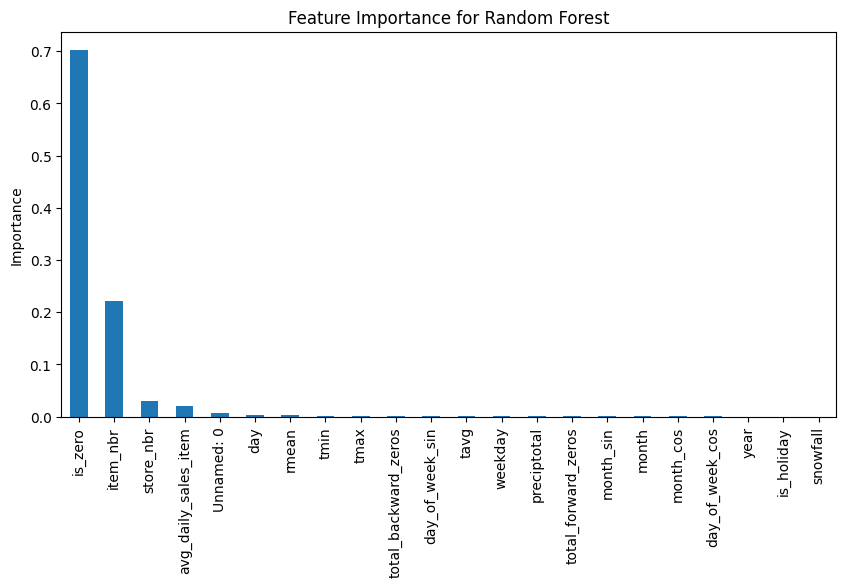

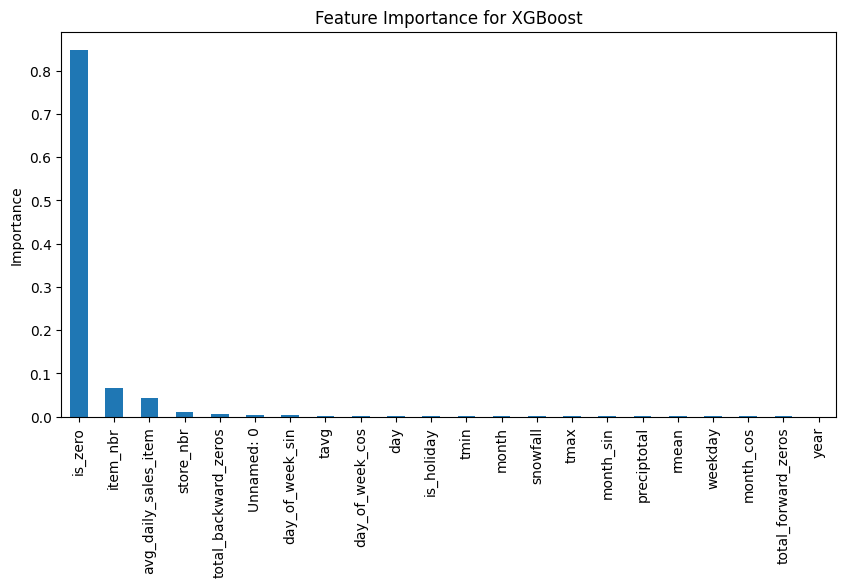

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        fi.plot(kind='bar', figsize=(10,5))
        plt.title(f'Feature Importance for {model_name}')
        plt.ylabel('Importance')
        plt.show()
    else:
        print(f"Model {model_name} does not support feature_importances_")

feature_names = df_train.drop(columns=['log1p']).columns

plot_feature_importance(models['RandomForest'], feature_names, 'Random Forest')
plot_feature_importance(models['XGBoost'], feature_names, 'XGBoost')


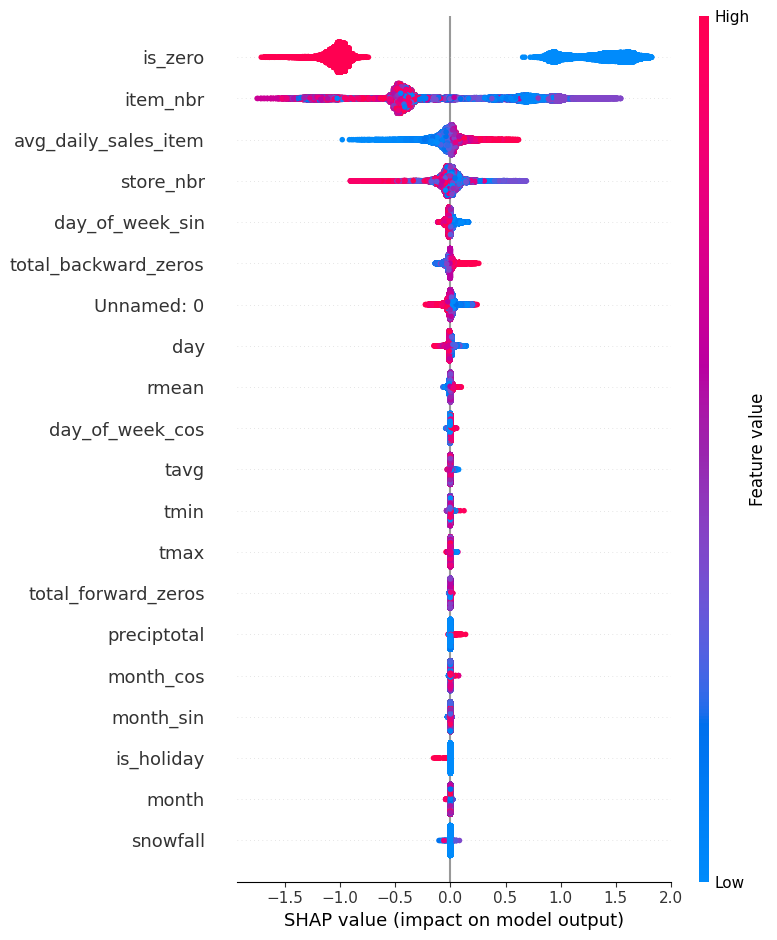

In [19]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df_train.drop(columns=['log1p'])
y = df_train['log1p']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test_imputed)

# Визуализация важности признаков
shap.summary_plot(shap_values, features=X_test_imputed, feature_names=feature_names)


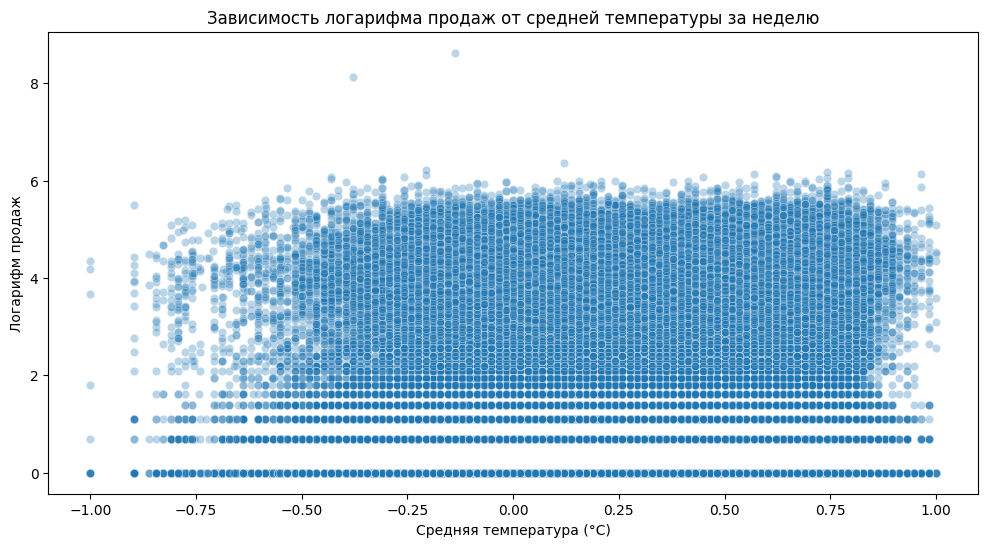

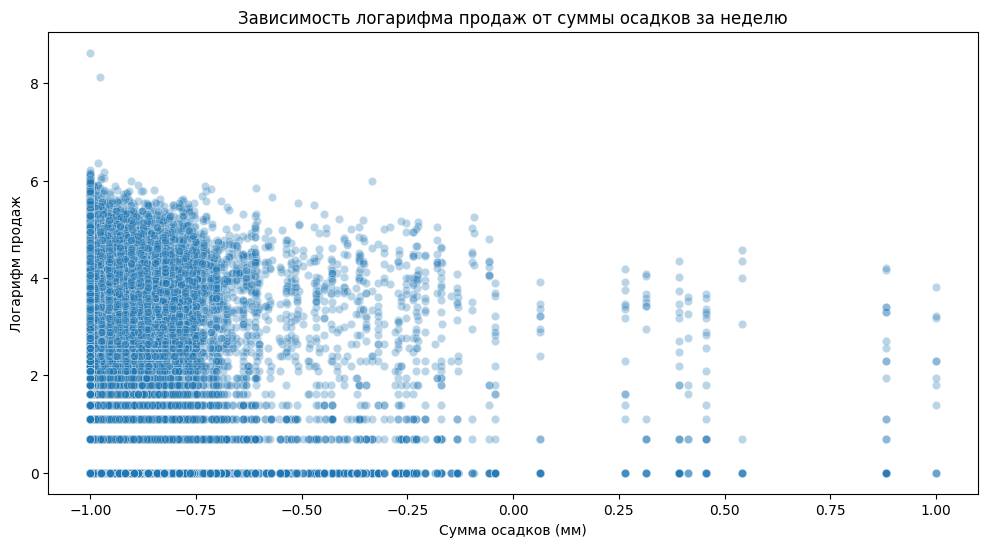

In [21]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='tavg', y='log1p', data=data, alpha=0.3)
plt.title('Зависимость логарифма продаж от средней температуры за неделю')
plt.xlabel('Средняя температура (°C)')
plt.ylabel('Логарифм продаж')
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x='preciptotal', y='log1p', data=data, alpha=0.3)
plt.title('Зависимость логарифма продаж от суммы осадков за неделю')
plt.xlabel('Сумма осадков (мм)')
plt.ylabel('Логарифм продаж')
plt.show()